<a href="https://colab.research.google.com/github/JoelMuhanguzi/mastersresearch/blob/main/urbannoiseclassifierv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install edgeimpulse

In [ ]:
#my code begins here
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 13.6 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-io

In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import seaborn as sns
import datetime
import librosa
from tensorflow import keras

In [ ]:
# import easyocr
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names_yam =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names_yam[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [ ]:
# Step 1: Load the class names from the text file
class_names = {
    1: 'car-or-truck', 2: 'motorvehicle-horn', 3: 'boda-boda-motocyle', 4: 'motorvehicle-siren',
    5: 'car-alarm', 6: 'mobile-music', 7: 'hawker-vendor', 8: 'community-radio', 9: 'regilious-venue',
    10: 'herbalists', 11: 'construction-site', 12: 'fabrication-workshop', 13: 'generator',
    14: 'bar-restaurant-nightclub', 15: 'animal', 16: 'crowd-noise', 17: 'school', 18: 'street-preacher',
    0: 'other'
}

In [ ]:
# Step 2: Function to Load the data and generate labels
def load_data(folder_path):
    data = []
    labels = []
    target = []
    for class_id, class_name in class_names.items():
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_folder, filename)
                data.append(file_path)
                labels.append(class_name)
                target.append(class_id)
    pd_data = pd.DataFrame({'filename': data, 'category': labels, 'target':target})
    # return data, labels, target
    return pd_data

In [ ]:
pd_data = load_data('/content/drive/Shareddrives/Sunbird AI/Projects/Noise pollution/Data/noisedata/tfdata/tfnoisedata')

In [ ]:
pd_data.head()

,filename,category,target
0,/content/drive/Shareddrives/Sunbird AI/Project...,car-or-truck,1
1,/content/drive/Shareddrives/Sunbird AI/Project...,car-or-truck,1
2,/content/drive/Shareddrives/Sunbird AI/Project...,car-or-truck,1
3,/content/drive/Shareddrives/Sunbird AI/Project...,car-or-truck,1
4,/content/drive/Shareddrives/Sunbird AI/Project...,car-or-truck,1


In [ ]:
pd_data.shape

(988, 3)

In [ ]:
category_count = pd_data['category'].value_counts()

In [ ]:
print(category_count)

car-or-truck                52
construction-site           52
street-preacher             52
school                      52
crowd-noise                 52
animal                      52
bar-restaurant-nightclub    52
generator                   52
fabrication-workshop        52
herbalists                  52
motorvehicle-horn           52
regilious-venue             52
community-radio             52
hawker-vendor               52
mobile-music                52
car-alarm                   52
motorvehicle-siren          52
boda-boda-motocyle          52
other                       52
Name: category, dtype: int64


In [ ]:
min_count = category_count.min()

In [ ]:
print(min_count)

52


In [ ]:
balanced_df =pd.DataFrame()
for label in pd_data['category'].unique():
  cat_data = pd_data[pd_data['category'] == label].iloc[:10]
  balanced_df = pd.concat([balanced_df,cat_data],ignore_index=True)

In [ ]:
balanced_df.head()

,filename,category,target
0,/content/drive/Shareddrives/Sunbird AI/Project...,car-or-truck,1
1,/content/drive/Shareddrives/Sunbird AI/Project...,car-or-truck,1
2,/content/drive/Shareddrives/Sunbird AI/Project...,car-or-truck,1
3,/content/drive/Shareddrives/Sunbird AI/Project...,car-or-truck,1
4,/content/drive/Shareddrives/Sunbird AI/Project...,car-or-truck,1


In [ ]:
balanced_df.shape

(190, 3)

In [ ]:
category_count = balanced_df['category'].value_counts()

In [ ]:
print(category_count)

car-or-truck                10
construction-site           10
street-preacher             10
school                      10
crowd-noise                 10
animal                      10
bar-restaurant-nightclub    10
generator                   10
fabrication-workshop        10
herbalists                  10
motorvehicle-horn           10
regilious-venue             10
community-radio             10
hawker-vendor               10
mobile-music                10
car-alarm                   10
motorvehicle-siren          10
boda-boda-motocyle          10
other                       10
Name: category, dtype: int64


In [ ]:
pd_data.category.unique()

array(['car-or-truck', 'motorvehicle-horn', 'boda-boda-motocyle',
       'motorvehicle-siren', 'car-alarm', 'mobile-music', 'hawker-vendor',
       'community-radio', 'regilious-venue', 'herbalists',
       'construction-site', 'fabrication-workshop', 'generator',
       'bar-restaurant-nightclub', 'animal', 'crowd-noise', 'school',
       'street-preacher', 'other'], dtype=object)

In [ ]:
pd_data = balanced_df

In [ ]:
pd_data.shape

(988, 3)

In [ ]:
balanced_df.category.unique()

array(['car-or-truck', 'motorvehicle-horn', 'boda-boda-motocyle',
       'motorvehicle-siren', 'car-alarm', 'mobile-music', 'hawker-vendor',
       'community-radio', 'regilious-venue', 'herbalists',
       'construction-site', 'fabrication-workshop', 'generator',
       'bar-restaurant-nightclub', 'animal', 'crowd-noise', 'school',
       'street-preacher', 'other'], dtype=object)

In [ ]:
my_classes = list(pd_data.category.unique())
print(my_classes)

['car-or-truck', 'motorvehicle-horn', 'boda-boda-motocyle', 'motorvehicle-siren', 'car-alarm', 'mobile-music', 'hawker-vendor', 'community-radio', 'regilious-venue', 'herbalists', 'construction-site', 'fabrication-workshop', 'generator', 'bar-restaurant-nightclub', 'animal', 'crowd-noise', 'school', 'street-preacher', 'other']


In [ ]:
filenames = pd_data['filename']
targets = pd_data['target']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
@tf.function
def load_wav_for_map(filename, label):
  return load_wav_16k_mono(filename), label

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings, tf.repeat(label, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
############### Testing out new split with shuffle ######################

import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you have a list or numpy array containing your data, replace data_array with your actual data
# data_array = np.arange(100)

# Define the proportions for training, testing, and validation
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Split the data into training and temporary data (test + validation)
# Get the total number of samples in the dataset
total_samples = len(list(main_ds.as_numpy_iterator()))

# Calculate the number of samples for each split
num_train = int(total_samples * train_ratio)
num_test = int(total_samples * test_ratio)

# Split the dataset into training, test, and validation sets
main_ds = main_ds.shuffle(total_samples, seed=42)  # Shuffle the dataset before splitting

train_ds = main_ds.take(num_train)
remaining_ds = main_ds.skip(num_train)
test_ds = remaining_ds.take(num_test)
val_ds = remaining_ds.skip(num_test)

# Print the number of samples in each split
# print("Number of samples in Train set:", len(list(train_ds.as_numpy_iterator())))
# print("Number of samples in Test set:", len(list(test_ds.as_numpy_iterator())))
# print("Number of samples in Validation set:", len(list(val_ds.as_numpy_iterator())))

In [ ]:
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 dense_21 (Dense)            (None, 19)                9747      
                                                                 
Total params: 534547 (2.04 MB)
Trainable params: 534547 (2.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 19)                9747      
                                                                 
Total params: 797203 (3.04 MB)
Trainable params: 797203 (3.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
# Plot training history
def plot_history(history):
    # Get training history values
    loss = history.history['loss']
    accuracy = history.history['accuracy']

    # Create subplots
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

    # Plot training loss
    ax[0].plot(loss, label='Training Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot training accuracy
    ax[1].plot(accuracy, label='Training Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

Epoch 1/50
579/579 [==============================] - 251s 209ms/step - loss: 1.9182 - accuracy: 0.3991 - val_loss: 1.4954 - val_accuracy: 0.5207
Epoch 2/50
579/579 [==============================] - 2s 4ms/step - loss: 1.5989 - accuracy: 0.4810 - val_loss: 1.3959 - val_accuracy: 0.5389
Epoch 3/50
579/579 [==============================] - 3s 5ms/step - loss: 1.4963 - accuracy: 0.5148 - val_loss: 1.3017 - val_accuracy: 0.5842
Epoch 4/50
579/579 [==============================] - 2s 3ms/step - loss: 1.4208 - accuracy: 0.5343 - val_loss: 1.2126 - val_accuracy: 0.6079
Epoch 5/50
579/579 [==============================] - 2s 3ms/step - loss: 1.3558 - accuracy: 0.5557 - val_loss: 1.1336 - val_accuracy: 0.6308
Epoch 6/50
579/579 [==============================] - 2s 3ms/step - loss: 1.2996 - accuracy: 0.5746 - val_loss: 1.1010 - val_accuracy: 0.6399
Epoch 7/50
579/579 [==============================] - 2s 3ms/step - loss: 1.2555 - accuracy: 0.5873 - val_loss: 1.0391 - val_accuracy: 0.6589
Ep

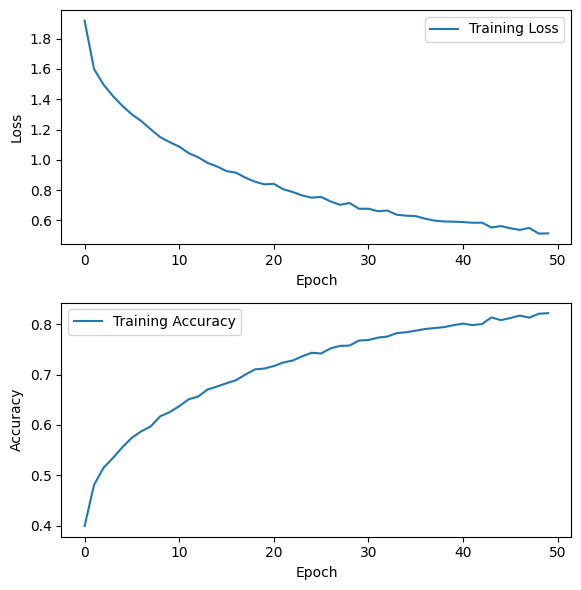

In [ ]:
history = my_model.fit(train_ds,
                       epochs=50,
                       validation_data=val_ds,
                       callbacks=callback)
plot_history(history)

In [ ]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

73/73 [==============================] - 118s 3ms/step - loss: 0.4887 - accuracy: 0.8721
Loss:  0.4887247085571289
Accuracy:  0.8721382021903992


In [ ]:
from sklearn.metrics import confusion_matrix

73/73 [==============================] - 0s 2ms/step


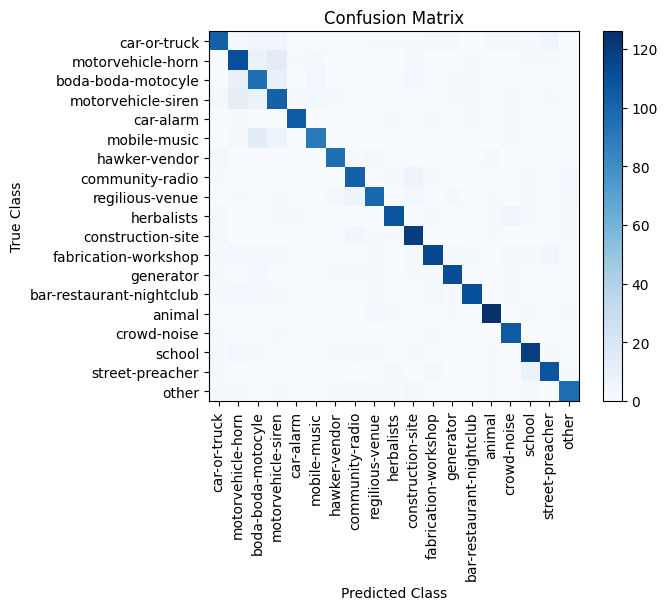

In [ ]:
# Get the predictions for the test dataset
y_pred = np.argmax(my_model.predict(test_ds), axis=1)

# Get the ground truth labels for the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(my_classes))
plt.xticks(tick_marks, my_classes, rotation=90)
plt.yticks(tick_marks, my_classes)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [ ]:
saved_model_path = '/content/drive/MyDrive/Masters/SavedModelFiles/finalnoisecolab_3.h5'

In [ ]:
saved_model_path = '/content/drive/MyDrive/Masters/SavedModelFiles/finalnoisecolab_v4'

In [ ]:
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

**Plot Graphic for Model Structure**

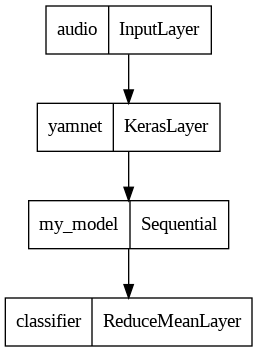

In [ ]:
tf.keras.utils.plot_model(serving_model)

In [ ]:
#testing_wav_file_name = output_file
testing_wav_file_name = '/content/drive/MyDrive/Masters/testdata/SB1005-2023-06-12T211309-81_converted.wav'
print(testing_wav_file_name)

/content/drive/MyDrive/Masters/testdata/SB1005-2023-06-12T211309-81_converted.wav


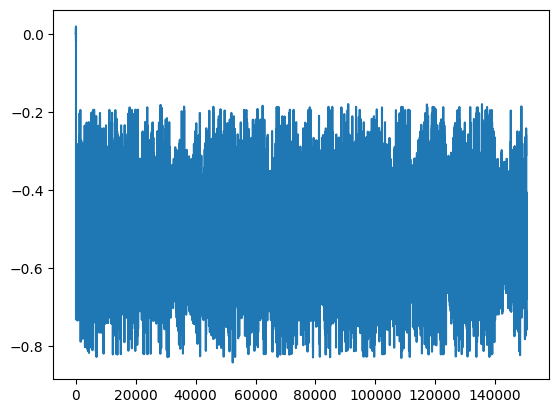

In [ ]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: motorvehicle-siren


In [ ]:
reloaded_results = serving_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]

#inferred_class = my_classes[reloaded_results.mean(axis=0).argmax()]
print(f'The main sound is: {cat_or_dog}')

The main sound is: motorvehicle-siren


In [ ]:
model_path = '/content/drive/MyDrive/Masters/SavedModelFiles/finalnoisecolab_v4'
reloaded_model = tf.saved_model.load(model_path)

In [ ]:
testing_wav_data = testing_wav_file_name

In [ ]:
reloaded_results = reloaded_model(testing_wav_data)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[Your model] The main sound is: motorvehicle-siren (0.5053564310073853)


In [ ]:
# Determine the class with the highest probability
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]

# Calculate class probabilities using softmax and convert to NumPy array
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1).numpy()

# Print the inferred class and its probability
print(f'[Your model] The main sound is: {your_inferred_class} ({class_probabilities[your_top_class]})')

# Print probabilities of all classes
for i, class_prob in enumerate(class_probabilities):
    class_name = my_classes[i]
    #print(f'Class: {class_name}, Probability: {class_prob}')
    print(f'Class: {class_name}, Probability: {class_prob:.4f}')

[Your model] The main sound is: motorvehicle-siren (0.5053564310073853)
Class: car-or-truck, Probability: 0.0001
Class: motorvehicle-horn, Probability: 0.4864
Class: boda-boda-motocyle, Probability: 0.0018
Class: motorvehicle-siren, Probability: 0.5054
Class: car-alarm, Probability: 0.0006
Class: mobile-music, Probability: 0.0027
Class: hawker-vendor, Probability: 0.0000
Class: community-radio, Probability: 0.0000
Class: regilious-venue, Probability: 0.0000
Class: herbalists, Probability: 0.0000
Class: construction-site, Probability: 0.0000
Class: fabrication-workshop, Probability: 0.0029
Class: generator, Probability: 0.0000
Class: bar-restaurant-nightclub, Probability: 0.0000
Class: animal, Probability: 0.0000
Class: crowd-noise, Probability: 0.0000
Class: school, Probability: 0.0000
Class: street-preacher, Probability: 0.0000
Class: other, Probability: 0.0000


In [ ]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(reloaded_model)
# Set optimization options
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # Use float16 data type
tflite_model = converter.convert()

with open('test1.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
def representative_data_gen():
    for input_value, _ in train_ds.batch(1).take(100):
        yield [input_value]

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(reloaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set the representative dataset
converter.representative_dataset = representative_data_gen

try:
    # Attempt to convert the model
    tflite_model = converter.convert()
except Exception as e:
    # Catch any conversion errors and print the error message
    print("TFLite conversion error:", e)

# Save the TFLite model
with open("test2.tflite", "wb") as f:
    f.write(tflite_model)


In [ ]:
# Define a smaller representative dataset
def representative_data_gen():
    for input_value, _ in train_ds.batch(1).take(100):
        # Normalize input_value to the range [-1, 1] (modify this based on your input data)
        normalized_input = input_value / 32768.0  # Assuming 16-bit signed PCM audio input
        yield [normalized_input]

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(reloaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

try:
    # Attempt to convert the model
    tflite_model = converter.convert()
except Exception as e:
    # Catch any conversion errors and print the error message
    print("TFLite conversion error:", e)

# Save the TFLite model
with open("test4.tflite", "wb") as f:
    f.write(tflite_model)



/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


TFLite conversion error: tensorflow/lite/kernels/pad.cc:79 SizeOfDimension(op_context->paddings, 0) != op_context->dims (1 != 3)Node number 15 (PAD) failed to invoke.


Trying conversion using EDGE IMPULSE TOOLS

In [ ]:
import edgeimpulse as ei

In [ ]:
ei.API_KEY = "ei_6f0488e38dd0c6c37a9afec36d6f202c818ca9d93a2abdd6b76f41af4b4b7a34	"

In [ ]:
ei.model.list_profile_devices()

['alif-he',
 'alif-hp',
 'arduino-nano-33-ble',
 'arduino-nicla-vision',
 'portenta-h7',
 'brainchip-akd1000',
 'cortex-m4f-80mhz',
 'cortex-m7-216mhz',
 'espressif-esp32',
 'himax-we-i',
 'infineon-cy8ckit-062s2',
 'infineon-cy8ckit-062-ble',
 'jetson-nano',
 'mbp-16-2020',
 'nordic-nrf52840-dk',
 'nordic-nrf5340-dk',
 'nordic-nrf9160-dk',
 'raspberry-pi-4',
 'raspberry-pi-rp2040',
 'renesas-ck-ra6m5',
 'renesas-rzv2l-cpu',
 'renesas-rzv2l',
 'st-iot-discovery-kit',
 'seeed-sense-cap',
 'wio-terminal',
 'seeed-vision-ai',
 'silabs-xg24',
 'silabs-thunderboard-sense-2',
 'sony-spresense',
 'synaptics-ka10000',
 'ti-am62a',
 'ti-am68a',
 'ti-launchxl',
 'ti-tda4vm']

In [ ]:
#estimate ram, rom and inference
try:
  profile = ei.model.profile(model='/content/3Aug2023-9_tflite_model.tflite',device='arduino-nano-33-ble')
  print(profile.summary())
except Exception as e:
  print(f"could not find profile: {e}")

Target results for int8:
{
    "device": "arduino-nano-33-ble",
    "tfliteFileSizeBytes": 802960,
    "isSupportedOnMcu": true,
    "memory": {
        "tflite": {
            "ram": 5313,
            "rom": 826888,
            "arenaSize": 5113
        },
        "eon": {
            "ram": 3336,
            "rom": 812216
        }
    },
    "timePerInferenceMs": 38
}


Performance on device types:
{
    "variant": "int8",
    "lowEndMcu": {
        "description": "Estimate for a Cortex-M0+ or similar, running at 40MHz",
        "timePerInferenceMs": 343,
        "memory": {
            "tflite": {
                "ram": 5224,
                "rom": 824936
            },
            "eon": {
                "ram": 3304,
                "rom": 810680
            }
        },
        "supported": true
    },
    "highEndMcu": {
        "description": "Estimate for a Cortex-M7 or other high-end MCU/DSP, running at 240MHz",
        "timePerInferenceMs": 6,
        "memory": {
          

In [ ]:
# List the available profile target devices
ei.model.list_deployment_targets()

['zip',
 'arduino',
 'tinkergen',
 'cubemx',
 'wasm',
 'wasm-browser-simd',
 'tensorrt',
 'ethos',
 'synaptics-tensaiflow-lib',
 'drp-ai-lib',
 'meta-tf',
 'tidl-lib',
 'memryx-dfp',
 'tidl-lib-am62a',
 'tidl-lib-am68a',
 'slcc',
 'disco-l475vg',
 'arduino-nano-33-ble-sense',
 'arduino-nicla-vision',
 'espressif-esp32',
 'raspberry-pi-rp2040',
 'arduino-portenta-h7',
 'silabs-thunderboard2',
 'silabs-xg24',
 'himax-we-i',
 'himax-we-i-gnu',
 'infineon-cy8ckit-062s2',
 'infineon-cy8ckit-062-ble',
 'nordic-nrf52840-dk',
 'nordic-nrf5340-dk',
 'nordic-nrf9160-dk',
 'nordic-thingy53',
 'nordic-thingy91',
 'openmv',
 'openmv-fw',
 'sony-spresense',
 'sony-spresense-commonsense',
 'ti-launchxl',
 'synaptics-ka10000',
 'renesas-ck-ra6m5',
 'brickml',
 'alif-ensemble-e7',
 'seeed-grove-vision-ai',
 'seeed-sensecap',
 'runner-linux-aarch64',
 'runner-linux-armv7',
 'runner-linux-x86_64',
 'runner-linux-aarch64-akd1000',
 'runner-linux-x86_64-akd1000',
 'runner-linux-x86_64-memryx-mx3',
 'runner

In [ ]:
deploy_filename = '/content/drive/MyDrive/Masters/finalnoisecolab/blenoiselib.zip'

In [ ]:
# Set model information, such as your list of labels
model_output_type = ei.model.output_type.Classification(labels=my_classes)
model_input_type = ei.model.input_type.AudioInput(16000)

# Create C++ library with trained model
deploy_bytes = None
try:

    deploy_bytes = ei.model.deploy(model='/content/3Aug2023-9_tflite_model.tflite',
                                   model_output_type=model_output_type,
                                   model_input_type=model_input_type,
                                   deploy_target='arduino')
except Exception as e:
    print(f"Could not deploy: {e}")

# Write the downloaded raw bytes to a file
if deploy_bytes:
    with open(deploy_filename, 'wb') as f:
        f.write(deploy_bytes.getvalue())

In [ ]:
!pip install everywhereml>=0.2.12

In [ ]:
!pip install tinymlgen

In [ ]:
from tinymlgen import port

# tf_model = create_tf_network()
# print(port(my_model, optimize=False))


# tf_model = create_tf_network()
output = port(my_model, optimize=True)
with open('model_code.h', 'w') as f:
    f.write(output)


In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [ ]:
# Write TFLite model to a C source (or header) file
with open('updatedlib' + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model_quant, 'blecode'))

In [ ]:
# Load TFLite model and see some details about input/output
tflite_interpreter = tf.lite.Interpreter(model_path='/content/3Aug2023-9_tflite_model (1).tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_embedding:0
shape: [   1 1024]
type: <class 'numpy.uint8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 19]
type: <class 'numpy.uint8'>
